In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain

In [2]:
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df = df[df['radiant_win'].notnull()]

2017-06-09 21:23:16.326129
Using this many files 4088


In [3]:
df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [6]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'camps_stacked', 'abandons', 'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [7]:
df['match_id'].values.tolist()

[3215454208,
 3215203072,
 3215290368,
 3215408384,
 3215363584,
 3215374336,
 3215354880,
 3215119616,
 3215297024,
 3215286272,
 3215157760,
 3215228160,
 3215247872,
 3215235840,
 3215395072,
 3215159296,
 3215482368,
 3215328256,
 3215344384,
 3215312384,
 3215131648,
 3215421440,
 3215233536,
 3215246080,
 3215390976,
 3215304704,
 3215160064,
 3215171072,
 3215266816,
 3215122432,
 3215379968,
 3215126272,
 3215100672,
 3215109888,
 3215352576,
 3215355392,
 3215301632,
 3215242752,
 3215258624,
 3215308032,
 3215488512,
 3215438848,
 3215143168,
 3215293440,
 3215415808,
 3215137280,
 3215396608,
 3215382784,
 3215313920,
 3215351040,
 3215341824,
 3215473664,
 3215373312,
 3215446528,
 3215276032,
 3215131904,
 3215132416,
 3215342848,
 3215388672,
 3215175680,
 3215419136,
 3215316480,
 3215208960,
 3215271168,
 3215386880,
 3215436032,
 3215202304,
 3215130112,
 3215368704,
 3215205376,
 3215129088,
 3215135744,
 3215425792,
 3215355648,
 3215174144,
 3215495424,
 3215468032,

In [8]:
df['residual'].values.tolist()

[20.125112533569336,
 16.850690841674805,
 15.006295204162598,
 14.988556861877441,
 14.782685279846191,
 13.677559852600098,
 13.661187171936035,
 13.582871437072754,
 13.316977500915527,
 13.169499397277832,
 13.039385795593262,
 12.983055114746094,
 12.933111190795898,
 12.821625709533691,
 12.772019386291504,
 12.724064826965332,
 12.21872615814209,
 12.17296314239502,
 12.164359092712402,
 12.100647926330566,
 12.001799583435059,
 11.905208587646484,
 11.803067207336426,
 11.778265953063965,
 11.628754615783691,
 11.536473274230957,
 11.34953784942627,
 11.322101593017578,
 11.297518730163574,
 11.278440475463867,
 11.22713565826416,
 11.221271514892578,
 11.036090850830078,
 11.009903907775879,
 10.957135200500488,
 10.917933464050293,
 10.8740873336792,
 10.841779708862305,
 10.755853652954102,
 10.703261375427246,
 10.671629905700684,
 10.65213680267334,
 10.626065254211426,
 10.593832015991211,
 10.55199146270752,
 10.533696174621582,
 10.470938682556152,
 10.448590278625488,


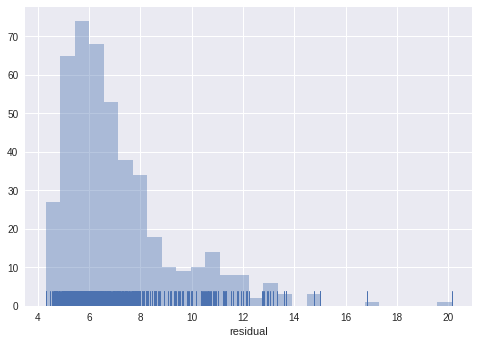

In [9]:
sns.distplot(df['residual'],  kde=False, rug=True)
plt.show()

In [10]:
len(df)

452

In [11]:
plt.close()

In [12]:
residuals = df['residual'].values.tolist()

In [13]:
np.max(residuals) - np.min(residuals)

15.805953025817871

In [14]:
df['residual']

291    20.125113
97     16.850691
427    15.006295
251    14.988557
236    14.782685
81     13.677560
99     13.661187
417    13.582871
254    13.316978
258    13.169499
345    13.039386
152    12.983055
337    12.933111
87     12.821626
113    12.772019
143    12.724065
399    12.218726
237    12.172963
188    12.164359
253    12.100648
368    12.001800
145    11.905209
332    11.803067
375    11.778266
136    11.628755
412    11.536473
223    11.349538
351    11.322102
202    11.297519
284    11.278440
         ...    
114     4.941914
76      4.940771
415     4.927406
50      4.872836
224     4.852162
132     4.850067
48      4.840608
428     4.840474
285     4.830542
404     4.816566
109     4.780591
442     4.761065
17      4.760531
219     4.738976
135     4.734292
261     4.732196
196     4.729854
220     4.724776
30      4.723308
10      4.693317
19      4.689787
29      4.671491
149     4.628952
429     4.626987
1       4.621526
80      4.612821
215     4.576520
211     4.4948

In [15]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKD(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

def heroGoldSpent(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_gold_spent']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

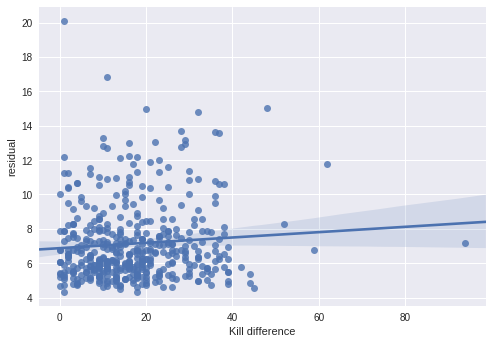

In [16]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

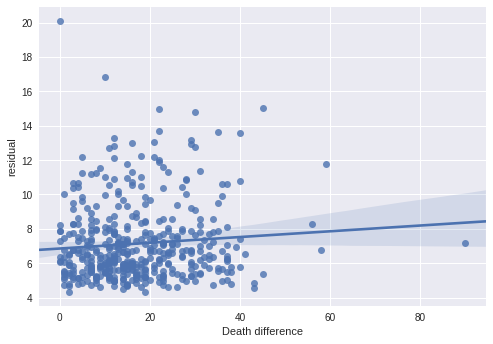

In [17]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

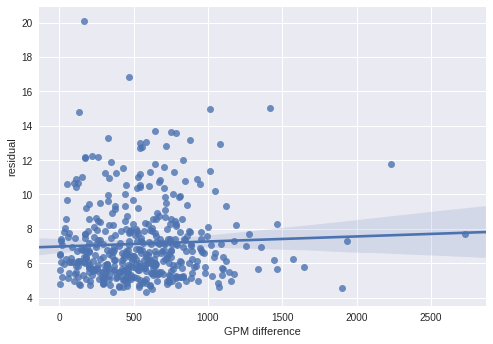

In [18]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

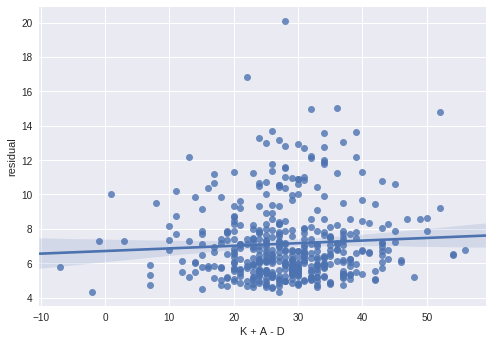

In [20]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

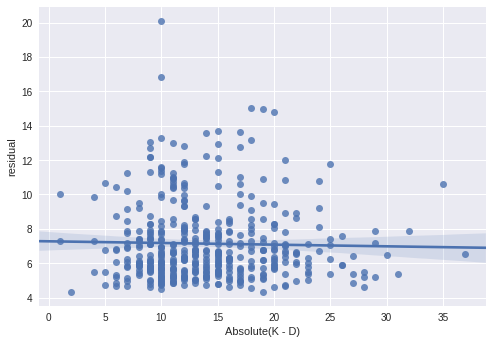

In [21]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

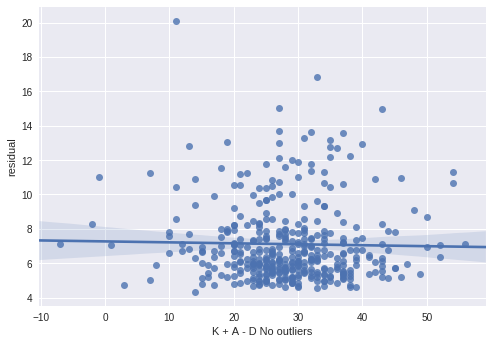

In [22]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

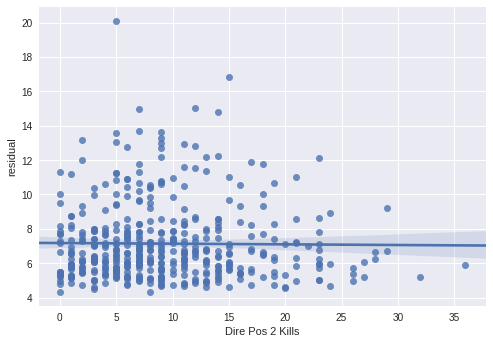

In [23]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

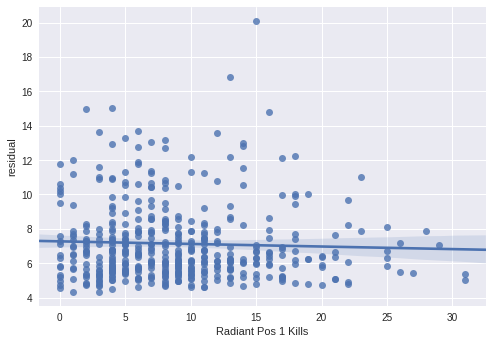

In [24]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

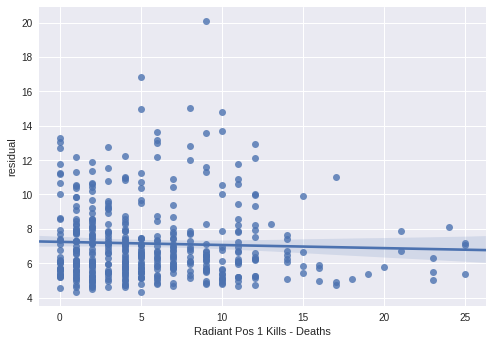

In [25]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

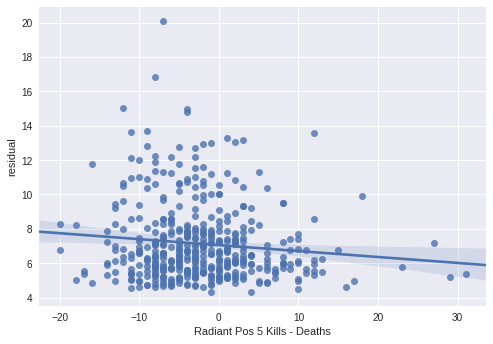

In [26]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

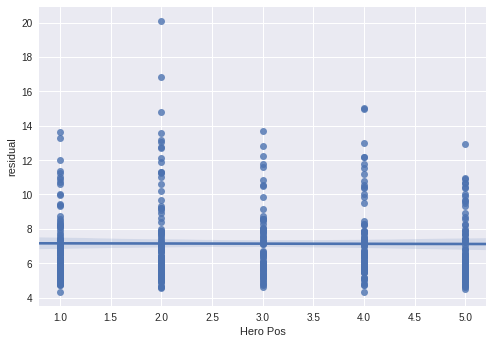

In [27]:
sns.regplot(df.apply(heroKD, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Pos")
plt.show()

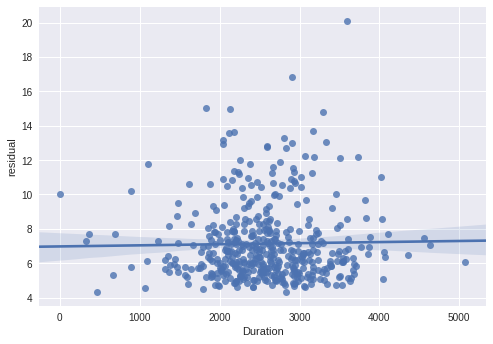

In [29]:
sns.regplot(df['duration'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Duration")
plt.show()

In [34]:
df[df['residual'] > 12]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
291,3215454208,0,0,170,True,3599,NaN,NaN,4,NaN,...,0,0,0,0,0,0,0,0,0,20.125113
97,3215203072,0,0,0,False,2902,NaN,NaN,4,NaN,...,0,0,1,0,0,0,0,0,0,16.850691
427,3215290368,0,0,112,False,1832,NaN,NaN,6,NaN,...,0,0,0,0,0,0,0,1,0,15.006295
251,3215408384,0,0,4,False,2126,NaN,NaN,9,NaN,...,0,0,0,0,0,0,0,0,0,14.988557
236,3215363584,0,0,64,True,3288,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,14.782685
81,3215374336,0,0,160,False,3163,NaN,NaN,16,NaN,...,0,0,0,0,0,0,0,0,0,13.677560
99,3215354880,0,0,51,False,2175,NaN,NaN,18,NaN,...,0,0,0,0,0,0,0,0,0,13.661187
417,3215119616,0,0,58,True,2118,NaN,NaN,4,NaN,...,0,0,0,0,0,0,0,0,0,13.582871
254,3215297024,0,0,96,False,2803,NaN,NaN,14,NaN,...,0,0,0,0,0,0,0,0,0,13.316978
258,3215286272,0,0,40,True,2040,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,13.169499


In [31]:
df[df['residual'] < 12].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
315,3215237632,0,0,74,True,2196,3.0,0.0,3,3.0,...,0,0,0,0,0,0,0,0,0,5.877406
130,3215109120,0,0,108,False,2911,NaN,NaN,6,NaN,...,0,0,0,0,0,0,0,0,0,5.903676
444,3215181568,0,0,177,True,3136,NaN,NaN,9,NaN,...,0,0,0,0,0,0,0,0,0,5.071773
227,3215282176,0,0,148,True,3664,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,0,0,5.620858
301,3215280896,0,0,8,True,1728,NaN,NaN,6,NaN,...,0,0,0,0,0,0,0,0,0,5.723104
134,3215465216,0,0,303,True,2068,NaN,NaN,9,NaN,...,0,0,0,0,0,0,0,0,0,6.774380
204,3215099392,0,0,302,False,2378,NaN,NaN,6,NaN,...,0,0,0,0,0,0,0,0,0,6.474863
54,3215451392,0,0,215,True,1384,NaN,NaN,2,NaN,...,0,0,1,0,0,0,0,0,0,5.868305
84,3215493376,0,0,171,False,2581,NaN,NaN,17,NaN,...,0,0,0,0,0,1,0,0,0,6.526466
442,3215386624,0,0,224,False,2933,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,4.761065


In [32]:
biggestAnom = np.loadtxt('data/anomalies.csv', delimiter = ',')
theirOutput = np.loadtxt('data/output.csv', delimiter = ",")

In [33]:
def whichIndex(row1, row2):
    largestError = -1
    index = -1
    for i in range(1, len(row1)):
        if abs(row1[i] - row2[i]) > largestError:
            largestError = abs(row1[i] - row2[i])
            index = i
    return index

for i in range(len(biggestAnom)):
    index = whichIndex(biggestAnom[i, :], theirOutput[i, :])
    df.columns[index]
    print biggestAnom[i, 0], df.columns[index], biggestAnom[i, index], theirOutput[i, index]

3215366144.0 dire_pos1_hero_dmg 0.902969717979 0.00140100717545
3215377920.0 dire_pos4_kda 0.986187636852 -0.000152051448822
3215442688.0 radiant_pos4_abandons 0.977224051952 -0.000752747058868
3215255040.0 radiant_pos5_observer_uses 0.733683586121 -0.00104296207428
3215369984.0 dire_pos5_observer_uses 0.98532474041 -0.00198328495026
3215376896.0 radiant_pos2_observer_uses 0.996239602566 -6.43879175186e-05
3215445248.0 dire_pos4_hero_dmg 0.651995003223 0.000428318977356
3215475712.0 dire_pos4_neutral_kills 0.989591896534 -0.000661253929138
3215167488.0 dire_pos2_tower_kills 0.788595020771 -0.000576615333557
3215271168.0 dire_pos5_ancient_kills 0.858123838902 0.000440627336502
3215255040.0 dire_pos4_observer_uses 0.740376114845 0.000225514173508
3215402496.0 radiant_pos5_lasthits 0.819570422173 -1.43051147461e-06
3215448064.0 dire_pos3_abandons 0.977136254311 0.000860929489136
3215494912.0 radiant_pos2_abandons 0.976650416851 -0.00148060917854
3215328000.0 radiant_pos2_kda 0.98199439048